# Calculating trainsition states

Identifying the most compute effective approach to calculating transition states can be difficult. Let us guide you through the options in this short notebook. **Pre-requisite: Familiarity with ASE**

Breakdown of this tutorial:
I.) Creating a work case
II.) Methods with examples
III.) Common problems and how to solve them

First, let us create a toy model of Au FCC(111) surface and 2 Cu ad atoms. 

In [2]:
from examples.data.model_gen import get_example_slab
slab_initial = get_example_slab(adsorbate=True, type="2Cu")

In the model above the two Cu atoms are situated on top of hcp adsorption sites. The final geometry will be with copper atoms placed in non-neighbouring fcc and hcp sites. The goal is to calculate the transition state between the two and an activation energy.

In [3]:
slab_final = get_example_slab(adsorbate=True, type="2Cu")
hcp_position = [slab_final[1].x, (slab_final[15].y + slab_final[1].y)/2]
# place the copper atom in the position specified above
slab_final[19].x, slab_final[19].y = hcp_position[0], hcp_position[1]

Now before we proceed we need to make sure the structures are optimised. Forces convergence criterion is usually below 0.01 eV/Angstrom on each individual atom, but for the purposes of this tutorial a looser 0.05 value is used.

In [4]:
from ase.optimize import FIRE
from ase.constraints import FixAtoms
# For the purpose of this tutorial a  constraint is set for all of the surface atoms
# Constraints used should always be specific to your system and applied following tests
freeze = FixAtoms([atom.index for atom in slab_initial if atom.tag > 0])
slab_initial.set_constraint(freeze)
slab_final.set_constraint(freeze)

opt = FIRE(slab_initial, trajectory="slab_initial.traj", restart="slab_initial.pckl")
opt.run(fmax=0.05)
opt = FIRE(slab_final, trajectory="slab_final.traj", restart="slab_final.pckl")
opt.run(fmax=0.05)

# You can have a look at the model using the visualizer
from ase.visualize import view
#view(slab_initial)
#view(slab_final)

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 12:13:22        9.933133*       1.8648
FIRE:    1 12:13:22        9.915770*       1.8756
FIRE:    2 12:13:22        9.880641*       1.8968
FIRE:    3 12:13:22        9.826952*       1.9280
FIRE:    4 12:13:22        9.753554*       1.9677
FIRE:    5 12:13:22        9.659050*       2.0131
FIRE:    6 12:13:22        9.542012*       2.0584
FIRE:    7 12:13:22        9.401488*       2.0916
FIRE:    8 12:13:22        9.219404*       2.0865
FIRE:    9 12:13:22        8.993709*       1.9603
FIRE:   10 12:13:22        8.747434*       1.5100
FIRE:   11 12:13:22        8.582779*       0.6554
FIRE:   12 12:13:22        8.701616*       2.8031
FIRE:   13 12:13:22        8.677077*       2.6013
FIRE:   14 12:13:22        8.634775*       2.2374
FIRE:   15 12:13:23        8.585337*       1.7795
FIRE:   16 12:13:23        8.539149*       1.3107
FIRE:   17 12:13:23        8.503149*       0.9278
FI

Now that we have the structures prepared, we need to look for an activation energy for transition between slab_initial and slab_final.

There are multiple ways one can approach this problem, but all will in the end help to establish highest energy geometry linking these two structures - the transition state.

    a.) NEB
    b.) MLNEB
    c.) AutoNEB
    d.) Surface diffusion energy barriers using ASE constraints - fixed plane
    e.) Surface diffusion energy barriers using ASE constraints - fixed bond lengths
    f.) Dimer Method (and Improved Dimer Method)
    g.) Growing String method
    h.) More are being developed

a.) Nudged Elastic Band - NEB

"The Nudged Elastic Band method is a technique for finding transition paths (and corresponding energy barriers) between given initial and final states. The method involves constructing a “chain” of “replicas” or “images” of the system and relaxing them in a certain way."

Detailed description of the NEB class as implemented in ASE, including useful publications:
https://wiki.fysik.dtu.dk/ase/ase/neb.html?highlight=neb#module-ase.neb
ASE take on this tutorial, exploring the functionality a bit more:
https://wiki.fysik.dtu.dk/ase/tutorials/neb/diffusion.html

The "classic" NEB is a bit of a brute force approach. It takes a lot of trial and error to get below convergence criteria and it is costly. All of the "images" mentioned above are optimised per iteration, so if one is interested in getting to know the Minimum Energy Path (MEP) better, often number of DFT calculations goes into thousands.

One of the problems associated with NEBs in general is that they rely heavily on the user-provided input structures. If they are not optimal due to complexity of the process, the MEP is elongated and the overall experiment becomes more expensive. There are ways of improving initial/final guesses, but not as straightforward with regular NEB.

To overcome the complexity of the energy landscape we need to focus solely on the highest energy transition state and ignore the lesser maxima, which can arise due to rotations etc. For this we use a *climbing image* calculation (see NEB wiki for more info).

In [5]:
# a) NEB code in ASE
from ase.neb import NEB
from ase.calculators.emt import EMT
import copy

# Make a band consisting of 7 images (including initial and final)
# Very important - each image has to have a separate calculator!
# If one wants to use a single calculator, e.g. sockets with FHI-aims,
# the SingleCalculatorNEB class needs to be used in instead
images = [slab_initial]
images += [slab_initial.copy() for i in range(5)]
images += [slab_final]
neb = NEB(images, climb=True) # use climbing image calculation
# Interpolate linearly the potisions of the three middle images:
neb.interpolate()
# Set calculators:
for image in images[1:6]:
    image.set_calculator(EMT())

# Optimize:
optimizer = FIRE(neb,
                trajectory='A2B.traj' # when running a real calculation make sure to save the output!
                 )
optimizer.run(fmax=0.05)

# Use ASE GUI to view the MEP
#view(images)


      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 12:13:27        7.452958*       0.8175
FIRE:    1 12:13:27        7.446831*       0.7324
FIRE:    2 12:13:27        7.437087*       0.5777
FIRE:    3 12:13:27        7.427528*       0.3802
FIRE:    4 12:13:27        7.421548*       0.1780
FIRE:    5 12:13:28        7.420847*       0.1145
FIRE:    6 12:13:28        7.420850*       0.1135
FIRE:    7 12:13:28        7.420858*       0.1117
FIRE:    8 12:13:28        7.420871*       0.1091
FIRE:    9 12:13:28        7.420892*       0.1058
FIRE:   10 12:13:28        7.420924*       0.1019
FIRE:   11 12:13:29        7.420969*       0.0976
FIRE:   12 12:13:29        7.421032*       0.0932
FIRE:   13 12:13:29        7.421124*       0.0884
FIRE:   14 12:13:29        7.421257*       0.0835
FIRE:   15 12:13:29        7.421442*       0.0791
FIRE:   16 12:13:29        7.421690*       0.0753
FIRE:   17 12:13:30        7.422009*       0.0724
FI

True

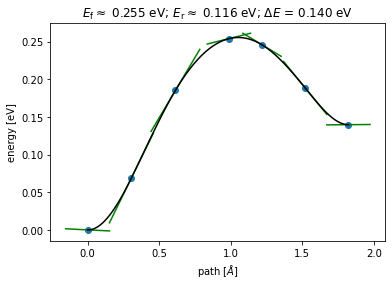

In [30]:
# Now let's analyse the output, if dealing with one calculation it is sufficient to use
# ASE GUI and choose Tools --> NEB to see the plot

import matplotlib.pyplot as plt
from ase.neb import NEBTools

nebtools = NEBTools(images)

# Get the calculated barrier and the energy change of the reaction.
Ef, dE = nebtools.get_barrier()

# Get the actual maximum force at this point in the simulation.
max_force = nebtools.get_fmax()

# Create a figure like that coming from ASE-GUI.
fig = nebtools.plot_band() # TODO: Why is this not generated when only runs once in Jupyter Notebook?
fig.savefig('barrier-neb.png')

b) Machine Learning NEB by CatLearn (MLNEB)

NEB images are generated and added dynamically based on the Gaussian Training Process. Each image is a product of a single-point calculation rather than optimisation. Overall efficiency in terms of resources should be increased by an order of magnitude.

If you use CatLearn's ML-NEB module, please cite:

   J. A. Garrido Torres, M. H. Hansen, P. C. Jennings,
   J. R. Boes and T. Bligaard. Phys. Rev. Lett. 122, 156001.
   https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.122.156001

In [7]:
from catlearn.optimize.mlneb import MLNEB
from ase.calculators.emt import EMT

# Desired nuber of images including start and end point
# Can be fraction e.g. 0.25, then the number of imaages is then determined automatically based on MEP length
n = 7 

calculator = EMT()
interpolation = "idpp" #or your own supplied path

# Setup the Catlearn object for MLNEB
neb_catlearn = MLNEB(start=slab_initial,
                     end=slab_final,
                     ase_calc=calculator,
                     n_images=n,
                     interpolation=interpolation, restart=False) #When True looks for evaluated_structures.traj

# Run the NEB optimisation. Adjust fmax to desired convergence criteria, usually 0.01 ev/A
neb_catlearn.run(fmax=0.05, trajectory='ML-NEB.traj', full_output=False, steps=75)

# Warning, this calculation takes some time on a local system, but it is little compared to DFT calculations
# on periodic surface models. Might not be ideal for trivial systems, e.g. small molecules in the gas phase.



/home/igor/.local/lib/python3.6/site-packages/ase/parallel.py:342: FutureWarning: ase.parallel.rank has been deprecated.  Please use ase.parallel.world.rank instead.
  FutureWarning)
/home/igor/.local/lib/python3.6/site-packages/ase/io/jsonio.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(obj)
/home/igor/.local/lib/python3.6/site-packages/ase/atoms.py:921: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


 
       ____      _   _                          
      / ___|__ _| |_| |    ___  __ _ _ __ _ __  
     | |   / _` | __| |   / _ \/ _` | '__| '_ \ 
     | |__| (_| | |_| |__|  __/ (_| | |  | | | |
      \____\__,_|\__|_____\___|\__,_|_|  |_| |_| ML-NEB 0.6.2
      
      
+--------+------+---------------------+---------------------+---------------------+--------------+--------------+----------+
| Method | Step |        Time         | Pred. barrier (-->) | Pred. barrier (<--) | Max. uncert. | Avg. uncert. |   fmax   |
+--------+------+---------------------+---------------------+------------------+--------------+--------------+----------+
| ML-NEB |     0| 2020-07-01 12:13:31 |             0.000000|             0.000000|      0.000000|      0.000000|  0.021585|
+--------+------+---------------------+---------------------+------------------+--------------+--------------+----------+
+--------+------+---------------------+---------------------+---------------------+--------------+---------

/home/igor/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx




+--------+------+---------------------+---------------------+---------------------+--------------+--------------+----------+
| Method | Step |        Time         | Pred. barrier (-->) | Pred. barrier (<--) | Max. uncert. | Avg. uncert. |   fmax   |
+--------+------+---------------------+---------------------+------------------+--------------+--------------+----------+
| ML-NEB |     0| 2020-07-01 12:13:36 |             0.000000|             0.000000|      0.000000|      0.000000|  0.021585|
| ML-NEB |     1| 2020-07-01 12:13:36 |             0.000000|             0.000000|      0.000000|      0.000000|  0.720728|
| ML-NEB |     2| 2020-07-01 12:13:36 |             0.144320|             0.004670|      0.095090|      0.053250|  1.800703|
+--------+------+---------------------+---------------------+------------------+--------------+--------------+----------+


Training a Gaussian process...
Number of training points: 4
Gaussian process trained.


+--------+------+---------------------+

In [8]:
# Check the output of MLNEB
from ase.io import read
#view(read("ML-NEB.traj@:"))

/home/igor/.local/lib/python3.6/site-packages/ase/io/jsonio.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(obj)


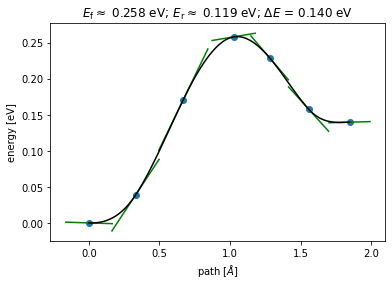

In [9]:
# Now let's analyse the output, if dealing with one calculation it is sufficient to use
# ASE GUI and choose Tools --> NEB to see the plot

import matplotlib.pyplot as plt
from ase.neb import NEBTools
from ase.io import read

nebtools = NEBTools(read("ML-NEB.traj@:"))

# Get the calculated barrier and the energy change of the reaction.
Ef, dE = nebtools.get_barrier()

# Get the actual maximum force at this point in the simulation.
max_force = nebtools.get_fmax()

# Create a figure like that coming from ASE-GUI.
fig = nebtools.plot_band()
fig.savefig('barrier-mlneb.png')


c) AutoNEB
https://wiki.fysik.dtu.dk/ase/dev/_modules/ase/autoneb.html
Similarly to MLNEB it adds images dynamically, but performs optimisations on each image sequentially.
Files need a strict naming scheme.

In [10]:
from ase.autoneb import AutoNEB
# AutoNEB requires a function that is assigning calculators to the generated images
def attach_calculators(images):
    for i in range(len(images)):
        images[i].set_calculator(EMT())
        
# Follow the naming scheme on input structures specified in 'prefix'
from ase.io.trajectory import Trajectory
import os
if not os.path.exists("neb000.traj"):
    initial_traj = Trajectory("neb000.traj", 'w')
    initial_traj.write(slab_initial)
    final_traj = Trajectory("neb001.traj", 'w')
    final_traj.write(slab_final)

### Autoneb settings
# number of images including initial and final
n = 7

neb = AutoNEB      (attach_calculators,
                    climb=True,
                    prefix = "neb",
                    n_max = n, # total no. images
                    n_simul= 1, # images in parallel - difficult to increase with FHI-aims, requires separate folders for each calc
                    optimizer = "FIRE", #or BFGS
                    fmax = 0.05, # make sure to change these
                    k = 0.05,
                    parallel = False
                    )

neb.run()

The NEB initially has 7 images  (including the end-points)
Start of evaluation of the initial images
Finished initialisation phase.
n_max images has been reached
****Now doing the CI-NEB calculation****


/home/igor/.local/lib/python3.6/site-packages/ase/io/jsonio.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(obj)


Now starting iteration 1 on  range(3, 6)


[Atoms(symbols='Au18Cu2', pbc=[True, True, False], cell=[[8.817000000000002, 0.0, 0.0], [4.408500000000001, 7.635745985167396, 0.0], [0.0, 0.0, 22.399683451346586]], tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]), calculator=SinglePointCalculator(...)),
 Atoms(symbols='Au18Cu2', pbc=[True, True, False], cell=[[8.817000000000002, 0.0, 0.0], [4.408500000000001, 7.635745985167396, 0.0], [0.0, 0.0, 22.399683451346586]], tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]), calculator=SinglePointCalculator(...)),
 Atoms(symbols='Au18Cu2', pbc=[True, True, False], cell=[[8.817000000000002, 0.0, 0.0], [4.408500000000001, 7.635745985167396, 0.0], [0.0, 0.0, 22.399683451346586]], tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]), calculator=SinglePointCalculator(...)),
 Atoms(symbols='Au18Cu2', pbc=[True, True, False], cell=[[8.8170000000000

/home/igor/.local/lib/python3.6/site-packages/ase/io/jsonio.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(obj)


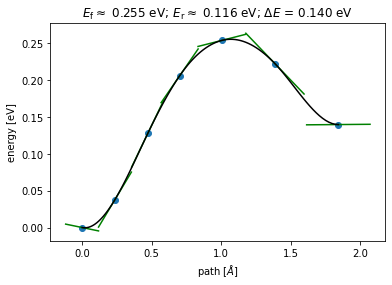

In [11]:
# from command line images can be joined together using:
# ase gui neb???.traj -n -1
from ase.io import read
images_autoneb = []
for i in range(n):
    atoms = read("neb00" + str(i) +".traj@-1")
    images_autoneb += [atoms]

from ase.visualize import view
#view(images_autoneb)

# Now let's analyse the output, if dealing with one calculation it is sufficient to use
# ASE GUI and choose Tools --> NEB to see the plot

import matplotlib.pyplot as plt
from ase.neb import NEBTools
from ase.io import read

nebtools = NEBTools(images_autoneb)

# Get the calculated barrier and the energy change of the reaction.
Ef, dE = nebtools.get_barrier()

# Get the actual maximum force at this point in the simulation.
max_force = nebtools.get_fmax()

# Create a figure like that coming from ASE-GUI.
fig = nebtools.plot_band()
fig.savefig('barrier-autoneb.png')


d) Surface diffusion energy barriers using ASE constraints - fixed plane

e.) Surface diffusion energy barriers using ASE constraints - fixed bond lengths
Highly mobile adsorbates (e.g. H) on surfaces in periodic calculations can cause issues during NEB due to low metastability on neighbouring adsorption sites, which means that: i) MEP length is elongated ii) Energy landscape can be very complicated. To address this one can apply constraints in ASE on bond length between specific atoms.
A function has been implemented in CARMM that helps to utilise this feature. 

Here let's try association, ie. reverse reaction and move Cu (atom index 19) closer and closer to the other Cu (atom index 18).

In [27]:
# BOND LENGTH SCAN - DISSOCIATION/ASSOCIATION
from carmm.build.neb.bond_length_scan import dissociation
from ase.io import read
from ase.io import Trajectory
import os
import numpy as np

model = slab_final
index1 = 18	# index of atom remaining in place (as part of molecule) 
index2 = 19	# index of atom dissociating/associationg

distance_Cu_Cu = np.linalg.norm(slab_initial[index1].position - slab_initial[index2].position)

atoms_list, distances = dissociation(model, 
                                     index1, 
                                     index2, 
                                     n_steps = 7,
                                     final_distance=distance_Cu_Cu,
                                    # step_size=0.1, # commented keywords are only used if final_distance is not set
                                    # reverse=False, 
                                     )

from ase.optimize import FIRE
from ase.calculators.emt import EMT

bl_scan = [slab_final] # list of all optimised structures will be generated

for atoms in atoms_list:
        # create naming scheme based on fixed Cu-Cu distance
        a_a_dist = np.linalg.norm(atoms[index1].position - atoms[index2].position)

        traj_name = "{:.2f}".format(a_a_dist) + ".traj"
        pckl_name = "{:.2f}".format(a_a_dist) + ".pckl"
        print(traj_name) # identify calculation in output
        
        
        # Remove inverted comas when running actual calculations to utilise previous calculations
        
        # include functionality for restart 
        if not os.path.exists(traj_name):
            pass
        else:
            atoms = read(traj_name)
        
        atoms.set_calculator(EMT())
        
        # optimise, include max steps for safety    
        opt = FIRE(atoms, trajectory=traj_name, restart=pckl_name)
        opt.run(fmax=0.05, steps=300)
        
        bl_scan += [atoms]


4.23.traj
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 12:30:57        7.334479*       0.0490
3.97.traj


/home/igor/.local/lib/python3.6/site-packages/ase/io/jsonio.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(obj)


      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 12:30:57        7.389349*       0.0389
3.72.traj
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 12:30:57        7.425697*       0.0399
3.46.traj
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 12:30:58        7.369449*       0.0434
3.20.traj
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 12:30:58        7.272971*       0.0426
2.95.traj
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 12:30:58        7.199702*       0.0404
2.69.traj
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 12:30:58        7.169759*       0.0407


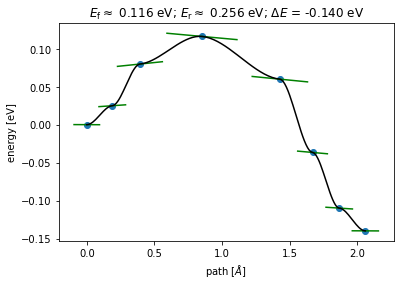

In [29]:
from ase.visualize import view
# view(bl_scan)

# Use the same tools as previously to analyse the output
# ASE GUI and choose Tools --> NEB to see the plot

import matplotlib.pyplot as plt
from ase.neb import NEBTools
from ase.io import read

nebtools = NEBTools(bl_scan)

# Get the calculated barrier and the energy change of the reaction.
Ef, dE = nebtools.get_barrier()

# Get the actual maximum force at this point in the simulation.
max_force = nebtools.get_fmax()

# Create a figure like that coming from ASE-GUI.
fig = nebtools.plot_band()
fig.savefig('barrier-mlneb.png')

# TODO: neb(✓), mlneb(✓), AutoNEB(✓) linear scan, (also Growing string?, Dimer method?)
# TODO: discuss indices in input structures (CO2 as example, avoid rotation during neb
# TODO: discuss symmetry operations (where possible) to reduce path size
# TODO: discuss difficult energy landscape, optimisations of local minima, dissociation with fixed bond lengths